# Predicting the Task-Scores from Responses

---

This notebook demonstrates the automation of the tasks scoring procedures using 
a BERT-model that is getting finetuned. It showcases several configuration choices 
that can be made to the procedure.

In [ ]:
model_name = "dbmdz/bert-base-german-uncased"
n_epochs = 3
finetune_taskwise = False
omit_tasknames = True
cv_splits = 3
oversample = False

# Temporary folder for the model
model_dir = "<NOT IN THIS REPO>"

## Setup

In [2]:
from torch.cuda import is_available as cuda_available
from torch.backends.mps import is_available as mps_available

import qutools.data as qtdata
import qutools.clustering as qtclst
import qutools.scoring as qtscore

In [ ]:
model_name_short = "bert"
results_path = f"data/output/scoring-results/finetune/{model_name_short}-{n_epochs}ep-{cv_splits}cv"
if omit_tasknames:
    results_path += "-notasknames"
if finetune_taskwise:
    results_path += "-taskwise"
if oversample:
    results_path += "-oversample"

In [ ]:
quconfig_path = qtdata.QuConfig.from_yaml("quconfigs/physics-pck.yaml")
quconfig = qtdata.QuConfig.from_yaml(quconfig_path)

qudata = qtdata.QuData(
    quconfig=quconfig,
    df_txt="<NOT IN THIS REPO>/booklets.xlsx",
    df_scr="<NOT IN THIS REPO>/pck-scores.xlsx",
    clip_sparingly_occurring_scores=True
)

quclst = qtclst.QuScoreClusters.from_dir("<NOT IN THIS REPO>/clst-model")

[99, '99', '', '-', '--', 'NA', 'Na', 'na', 'Null', 'null', ' ', 'nan', 'NaN', 'Nan', 'NAN', nan].
Checked ID-matches. ✓
Validated ID-columns. ✓
Validated text-columns. ✓
Cleaning text-data whitespaces. ✓
All scores in correct ranges. ✓
Validated score-columns. ✓
Found the following score proportions:
	 {0.0: '61.55 %', 1.0: '25.3 %', 2.0: '13.03 %', 3.0: '0.11 %'}
	-> Replacing according to {3.0: 2}
Loading QuData:
---------------
Checked ID-matches. ✓
Validated ID-columns. ✓
Validated text-columns. ✓
Cleaning text-data whitespaces. ✓
All scores in correct ranges. ✓
Validated score-columns. ✓
Scores-Shape: (846, 44)
---------------
Found QuSubscales containing the subscales:
['Reproduzieren', 'Anwenden-Kreieren', 'Analysieren-Evaluieren']
The following exploratory QuScoreClusters-Model has been found:
QuScoreClusters(
	- Config: QuestionnaireConfig(23 text, 4 multiple_choice)
	- Data: text-data: (846, 33) (items-cols) | score-data: (846, 44) (mc_items-cols)
	- Incomplete dropped (<0.5

In [5]:
device = "cuda" if cuda_available() else "mps" if mps_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


## Train Model

In [6]:
quscr = qtscore.QuFinetuneScorer(
    save_dir=model_dir,
    model_name=model_name,
    num_labels=qudata.get_n_classes(),
    item_task_prefix=omit_tasknames==False,
    it_repl_dict={"A": "Aufgabe "},
    sep=" [SEP] ",
)

quscr.set_training_args(
    n_epochs=n_epochs,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scoring Model: dbmdz/bert-base-german-uncased
Trainable: 109929987 / Total: 109929987
Did not find a stored `pretrained_language_model`.
No trained model to be saved.
Using the following training args:
 - n_epochs = 3
 - test_batch_size = 16
 - eval_steps = 200
 - logging_steps = 50
 - device = cuda
 - cv_training_stuck_attemts = 3
 - stuck_std_threshold_acc = 0.0001
 - stuck_std_threshold_loss = 0.01


The following cell also shows the cabability of the finetune-scorer to only fit 
cross-validation-splits, that have not been used already in the live-updated 
results-object stored in the `model_dir`.

	classlabels for new or unseen data might be inappropiate
	and might not even work, depending on the cluster model.


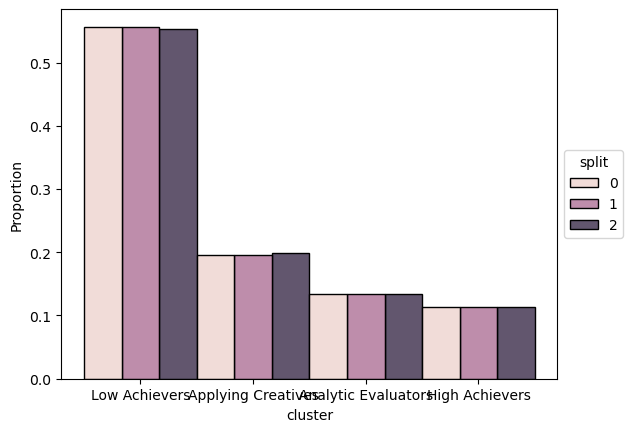

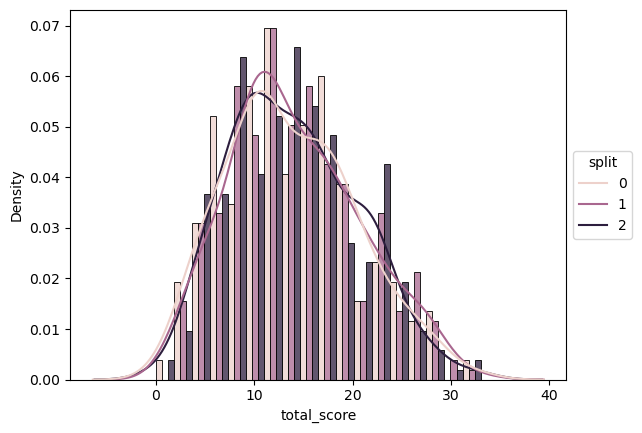

Generatred id-split (n_splits=3, random_state=5555, N-test=3) 

Info: There are persons/test edits without any valid text-responses, which will not 
	be included in the `.get_txt(...)`-method's result:
	['GR-B2-MZP1-EEA15' 'GR-B2-MZP1-IEE09']
- Word-Count (approx.): 262089
- Token-Count (exact.): 411090
- Token per Word (approx.): 1.57
- Document length exeeding embedding model's maximum sequence length:
	- Absolute: 0
	- Relative: 0.00 %
Loaded QuScorerResults from "temp/curr/qusr".

CV-Split 3 of 3:
---------------------------------------------------------------------------------------------------
Encoding:


Map:   0%|          | 0/10309 [00:00<?, ? examples/s]

Map:   0%|          | 0/5291 [00:00<?, ? examples/s]


Training:


Step,Training Loss,Validation Loss,Accuracy,F1
200,0.879600,0.793392,0.617464,0.596591
400,0.799000,0.742932,0.640144,0.616599
600,0.800800,0.729695,0.647137,0.646202
800,0.752900,0.720650,0.645436,0.628268
1000,0.755400,0.678938,0.687772,0.676554
1200,0.758600,0.710797,0.670573,0.661557
1400,0.582500,0.730755,0.679267,0.675465
1600,0.624300,0.683024,0.695332,0.693268
1800,0.585900,0.679857,0.690418,0.686534
2000,0.580800,0.684929,0.711964,0.708969



Storing Predictions:


100%|██████████| 331/331 [01:01<00:00,  5.40it/s]


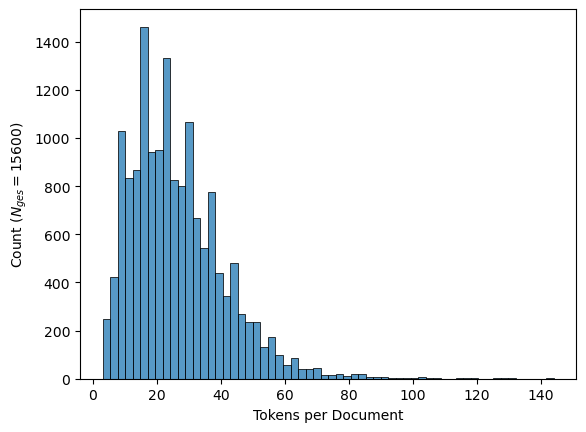

In [7]:
qusr = quscr.random_cross_validate(
    qudata=qudata,
    quclst=quclst,
    n_splits=cv_splits,
    finetune_taskwise=finetune_taskwise,
    oversample=oversample,
    continue_qusr=True,
    random_state=5555,
)

In [8]:
qusr.to_dir(results_path)

## Fully Train the Model

In [ ]:
quscr = qtscore.QuFinetuneScorer(
    save_dir="<NOT IN THIS REPO>/fully-trained-scorer/",
    model_name=model_name,
    num_labels=qudata.get_n_classes(),
    item_task_prefix=True,
    it_repl_dict={"A": "Aufgabe "},
    sep=" [SEP] ",
)

quscr.set_training_args(
    n_epochs=n_epochs,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scoring Model: dbmdz/bert-base-german-uncased
Trainable: 109929987 / Total: 109929987
Using the following training args:
 - n_epochs = 3
 - test_batch_size = 16
 - eval_steps = 200
 - logging_steps = 50
 - device = cuda
 - cv_training_stuck_attemts = 3
 - stuck_std_threshold_acc = 0.0001
 - stuck_std_threshold_loss = 0.01


In [ ]:
quscr.complete_data_fit(qudata=qudata)
quscr.save("<NOT IN THIS REPO>/fully-trained-scorer/")